In [ ]:
import pandas as pd
df = pd.read_pickle('df_independent_2013_2018_v2')
df_close = pd.read_pickle('df_aapl_2013_2018')

In [16]:
import numpy as np
df_train = df['2017':'2013']
df_test = df['2018']


Splitting and scaling the data

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(df_train.values)
test_data = scaler.transform(df_test.values)

In [18]:
x_train = train_data[:, :-1]
y_train = train_data[:, -1]

In [19]:
x_test = test_data[:, :-1]

BUILDING AN ARTIFICIAL NEURAL NETWORK WITH TENSORFLOW


First Phase is to assemble the graph

In [20]:
import tensorflow as tf

num_features = x_train.shape[1]

x = tf.placeholder(dtype=tf.float32, shape=[None, num_features])
y = tf.placeholder(dtype=tf.float32, shape=[None])

In [21]:
nl_1, nl_2, nl_3, nl_4 = 512, 256, 128, 64
wi = tf.contrib.layers.variance_scaling_initializer(
    mode='FAN_AVG', uniform=True, factor=1)
zi = tf.zeros_initializer()

In [22]:
# 4 Hidden layers
wt_hidden_1 = tf.Variable(wi([num_features, nl_1]))
bias_hidden_1 = tf.Variable(zi([nl_1]))

wt_hidden_2 = tf.Variable(wi([nl_1, nl_2]))
bias_hidden_2 = tf.Variable(zi([nl_2]))

wt_hidden_3 = tf.Variable(wi([nl_2, nl_3]))
bias_hidden_3 = tf.Variable(zi([nl_3]))

wt_hidden_4 = tf.Variable(wi([nl_3, nl_4]))
bias_hidden_4 = tf.Variable(zi([nl_4]))

# Output layer
wt_out = tf.Variable(wi([nl_4, 1]))
bias_out = tf.Variable(zi([1]))

In [23]:
hidden_1 = tf.nn.relu(
    tf.add(tf.matmul(x, wt_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(
    tf.add(tf.matmul(hidden_1, wt_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(
    tf.add(tf.matmul(hidden_2, wt_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(
    tf.add(tf.matmul(hidden_3, wt_hidden_4), bias_hidden_4))
out = tf.transpose(tf.add(tf.matmul(hidden_4, wt_out), bias_out))

mse = tf.reduce_mean(tf.squared_difference(out, y))
optimizer = tf.train.AdamOptimizer().minimize(mse)

Phase 2: training our model

In [24]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

c:\Users\ayanj\Projects\FinanceWithPython\tensor_env\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [25]:
from numpy import arange
from numpy.random import permutation

BATCH_SIZE = 100
EPOCHS = 100

for epoch in range(EPOCHS):
    shuffle_data = permutation(arange(len(y_train)))
    x_train = x_train[shuffle_data]
    y_train = y_train[shuffle_data]

    for i in range(len(y_train)//BATCH_SIZE):
        start = i*BATCH_SIZE
        batch_x = x_train[start:start+BATCH_SIZE]
        batch_y = y_train[start:start+BATCH_SIZE]
        session.run(optimizer, feed_dict={x: batch_x, y: batch_y})

In [26]:
[predicted_values] = session.run(out, feed_dict={x: x_test})

Plotting and predicting the actual values

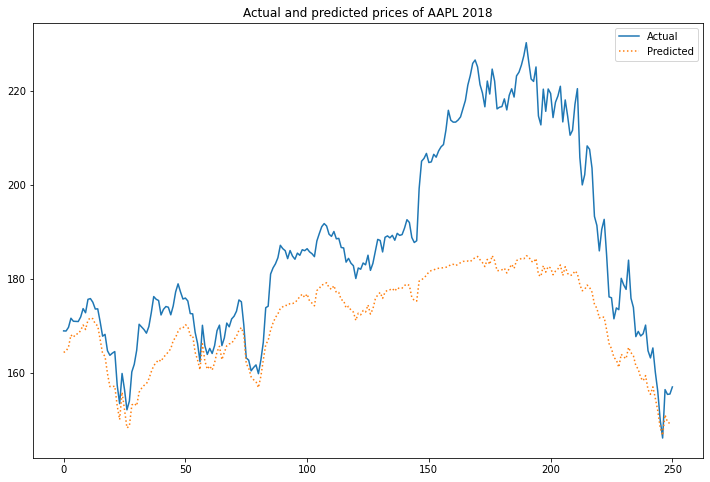

In [27]:
predicted_scaled_data = test_data.copy()
predicted_scaled_data[:, -1] = predicted_values
predicted_values = scaler.inverse_transform(predicted_scaled_data)

predictions = predicted_values[:, -1][::-1]
actual = df_close['2018']['adj_close_price'].values[::-1]

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title('Actual and predicted prices of AAPL 2018')
plt.plot(actual, label='Actual')
plt.plot(predictions, linestyle='dotted', label='Predicted')
plt.legend();



CREDIT CARD PAYMENT DEFAULT PREDICTION WITH KERAS

In [29]:
import pandas as pd
df = pd.read_csv("default_cc_clients.csv")

Splitting and scaling the data

In [30]:
feature_columns = df.columns[:-1]
features = df.loc[:, feature_columns]
target = df.loc[:, 'default payment next month']

from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = \
    train_test_split(features, target, test_size=0.20, random_state=0)



In [31]:
import numpy as np
train_x, train_y = np.array(train_features), np.array(train_target)
test_x, test_y = np.array(test_features), np.array(test_target)

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled_x = scaler.fit_transform(train_x)
test_scaled_x = scaler.transform(test_x)


Designing a deep neural network with 5 hidden layers using Keras

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

num_features = train_scaled_x.shape[1]

model = Sequential()
model.add(Dense(80, input_dim=num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                1920      
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                3240      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

Fit and train our model using the AdamOptimizer function again

In [43]:
import tensorflow as tf
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [44]:
from keras.callbacks import History 

callback_history = History()

model.fit(
    train_scaled_x, train_y,
    validation_split=0.2,
    epochs=100, 
    callbacks=[callback_history]
)




Train on 19200 samples, validate on 4800 samples
Epoch 1/100
19200/19200 [==============================] - 2s 84us/step - loss: 0.5052 - accuracy: 0.7820 - val_loss: 0.4905 - val_accuracy: 0.7760
Epoch 2/100
19200/19200 [==============================] - 1s 75us/step - loss: 0.4650 - accuracy: 0.8044 - val_loss: 0.4632 - val_accuracy: 0.8087
Epoch 3/100
19200/19200 [==============================] - 1s 72us/step - loss: 0.4585 - accuracy: 0.8054 - val_loss: 0.4542 - val_accuracy: 0.8069
Epoch 4/100
19200/19200 [==============================] - 1s 68us/step - loss: 0.4540 - accuracy: 0.8087 - val_loss: 0.4537 - val_accuracy: 0.8056
Epoch 5/100
19200/19200 [==============================] - 1s 68us/step - loss: 0.4508 - accuracy: 0.8098 - val_loss: 0.4532 - val_accuracy: 0.8087y:  - ETA: 0s - loss: 0.4507 - accuracy: 0.
Epoch 6/100
19200/19200 [==============================] - 1s 68us/step - loss: 0.4504 - accuracy: 0.8118 - val_loss: 0.4506 - val_accuracy: 0.8142
Epoch 7/100
19200

Measuring the persomance of our model

In [45]:
test_loss, test_acc = model.evaluate(test_scaled_x, test_y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6000/6000 [==============================] - 0s 22us/step
Test loss: 0.4284047478834788
Test accuracy: 0.8271666765213013


Graphing confusion matrix

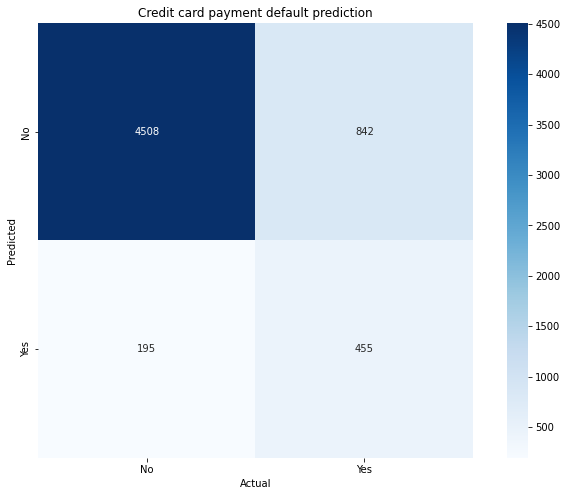

In [47]:
predictions = model.predict(test_scaled_x)
pred_values = predictions.round().ravel()

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_y, pred_values)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

flags = ['No', 'Yes']
plt.subplots(figsize=(12,8))
sns.heatmap(matrix.T, square=True, annot=True, fmt='g', cbar=True, 
    cmap=plt.cm.Blues, xticklabels=flags, yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Credit card payment default prediction');



Displaying recorded events in Keras History

In [51]:
train_acc = callback_history.history['accuracy']
val_acc = callback_history.history['val_accuracy']
train_loss = callback_history.history['loss']
val_loss = callback_history.history['val_loss']

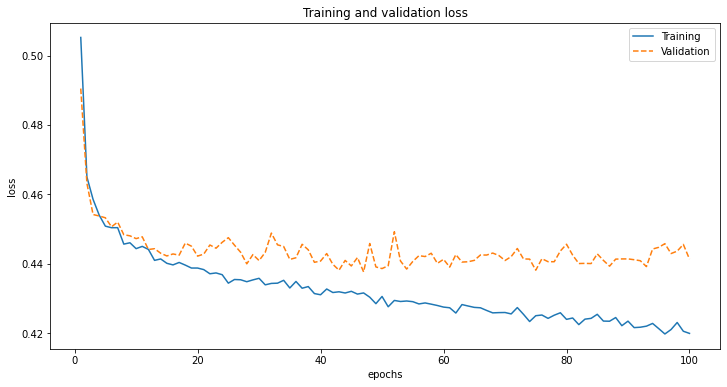

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc)+1)

plt.figure(figsize=(12,6))
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, val_loss, '--', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

<Figure size 432x288 with 0 Axes>

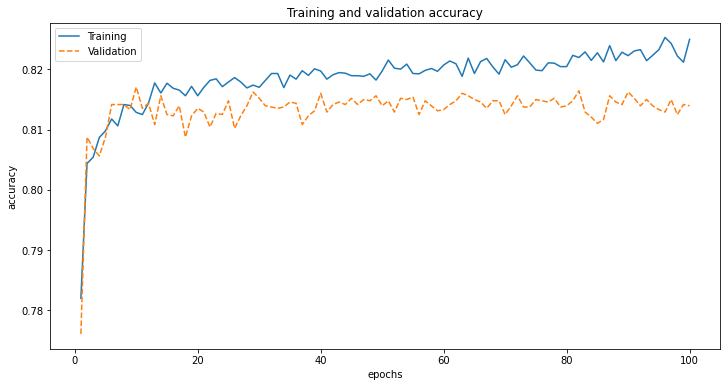

In [53]:
plt.clf()  # Clear the figure
plt.figure(figsize=(12,6))
plt.plot(epochs, train_acc, '-', label='Training')
plt.plot(epochs, val_acc, '--', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();